# Result Reader

This is a script to extract the results from the Results folder and plot them.

In [25]:
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
import itertools as iter
import numpy as np
import pandas as pd
import pickle
import os

In [26]:
# Helper function to extract results

def extract(location: str) -> list [tuple [list]]:

    results = []

    filenames = os.listdir(location)
    for filename in filenames:

        if filename[-2:] != ".b": continue

        try:

            with open(location + filename, "rb") as file:

                results.append(pickle.load(file))
        
        except Exception as e: print(location, ":", e)

    return results

In [27]:
# Helper function to find the mean of the results from all the devices

def reduce_avg(results):

    m = len(results)
    n = len(results[0])
    p = min(len(result[0]) for result in results)

    reduced_result = [[] for _ in range(n)]

    for i in range(n):
        for j in range(p):

            x = 0
            for result in results:
                x += result[i][j]

            reduced_result[i].append(x/m)

    return reduced_result

In [28]:
# Helper function to find the sum of the results from all the devices

def reduce_sum(results):

    m = len(results)
    n = len(results[0])
    p = min(len(result[0]) for result in results)

    reduced_result = [[] for _ in range(n)]

    for i in range(n):
        for j in range(p):

            x = 0
            for result in results:
                x += result[i][j]

            reduced_result[i].append(x)

    return reduced_result

In [29]:
# Helper function to smoothen the curves in the plots

def interpolate(X, n):

    m = len(X)
    x = np.arange(0, n + n/m, n/m)
    y = [0] + X

    spline = make_interp_spline(x, y)
    
    return spline(np.arange(0, n+1))

In [30]:
# Helper function to extract the results into a pandas dataframe

def read_results(results_location, columns = []):

    locations = os.listdir(results_location)
    locations = list(
        map(
            lambda x: x + "/",
            filter(
                lambda x: x.find(".") < 0,
                locations
            )
        )
    )

    if len(columns) == 0:
        
        columns = locations[0][:-1].split("_n_")
        columns = list(
            map(
                lambda x: x[:x.rfind("_v_")],
                columns
            )
        )

    columns = columns + ["total_shares", "train_acc", "train_loss", "test_acc", "test_loss"]

    data = []
    results = []

    def f(x):

        if x.rfind("_v_") > 0:
            
            try: return float(x[x.rfind("_v_")+3:].replace("_d_", "."))
            except: return x[x.rfind("_v_")+3:].replace("_d_", ".")

        return x

    for location in locations:

        row = location[:-1].split("_n_")
        row = list(map(f, row))

        extracted = extract(results_location + location)
        result = reduce_sum(extracted)[:1] +  reduce_avg(extracted)[1:]
        row += [x[-1] for x in result]

        data.append(row)
        results.append(result)

    data = pd.DataFrame(data, columns=columns)
    
    return results, data

In [31]:
# Helper function to plot the results

def plot_results(data, results, indices, legend, smoothen, axes):

    for i, l in zip(indices, legend):
        
        print("%s: %.2f %%" % (l, results[i][3][-1]*100))

    for i in indices:
        if smoothen > 0: plt.plot(interpolate(results[i][3], smoothen))
        else: plt.plot(results[i][3])

    plt.legend(legend)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel(axes[0])
    plt.ylabel(axes[1])
    plt.grid(axis = "y")

    plt.show()

In [32]:
results_location = "../../results/mnist-ml/"

ml_res, ml_df = read_results(
    results_location, 
    columns=[
        "config"
    ]
)

ml_df

,config,total_shares,train_acc,train_loss,test_acc,test_loss
0,ml,0,0.93335,0.242839,0.9261,0.264122


In [33]:
results_location = "../../results/mnist-final/noniid/"

noniid_res, noniid_df = read_results(
    results_location, 
    columns = [
        "config"
    ]
)

noniid_df

,config,total_shares,train_acc,train_loss,test_acc,test_loss
0,iid,40,0.916565,0.304321,0.91688,0.298446
1,noniid2,40,0.984083,0.062831,0.77622,0.660733
2,noniid5,40,0.952994,0.170558,0.87933,0.398014


In [34]:
results_location = "../../results/mnist-final/pcomm/"

pcomm_res, pcomm_df = read_results(
    results_location, 
    columns = [
        "config"
    ]
)

pcomm_df

,config,total_shares,train_acc,train_loss,test_acc,test_loss
0,e1,40,0.961505,0.156829,0.89979,0.357214
1,e10,40,0.984002,0.061162,0.77622,0.660714
2,e50,40,0.986761,0.045347,0.59598,1.271555


In [35]:
results_location = "../../results/mnist-final/topology/"

topo_res, topo_df = read_results(
    results_location, 
    columns = [
        "config",
        "graph_preset"
    ]
)

topo_df

,config,graph_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,noniid2,dense,40,0.984003,0.060400,0.77628,0.660460
1,noniid2,full,90,0.983886,0.062126,0.88820,0.445057
2,noniid2,sparse,18,0.985337,0.059338,0.51846,1.768376


In [36]:
results_location = "../../results/mnist-final/qneighbors/"

neigh_res, neigh_df = read_results(
    results_location, 
    columns = [
        "config",
        "graph_preset"
    ]
)

neigh_df

,config,graph_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,noniid2,bad,42,0.984911,0.057853,0.59140,1.367083
1,noniid2,good,42,0.983906,0.062332,0.83866,0.535458


In [37]:
results_location = "../../results/mnist-final/fedcurv/"

fedcurv_res, fedcurv_df = read_results(
    results_location, 
    columns = [
        "config",
        "curv_term"
    ]
)

fedcurv_df

,config,curv_term,total_shares,train_acc,train_loss,test_acc,test_loss
0,noniid2,0.01,40,0.964716,0.145359,0.85725,0.540600
1,noniid2,0.10,40,0.942461,0.256194,0.82254,0.666096
2,noniid2,1.00,40,0.920280,0.318250,0.85556,0.495193
3,noniid5,0.01,40,0.915115,0.303925,0.91636,0.302186
4,noniid5,0.10,40,0.908531,0.339879,0.91222,0.328214
5,noniid5,1.00,40,0.889981,0.431159,0.89606,0.416517


In [38]:
results_location = "../../results/mnist-final/stragglers/"

strag_res, strag_df = read_results(
    results_location, 
    columns = [
        "config",
        "stragglers",
        "num_seconds",
        "random_preset"
    ]
)

strag_df

,config,stragglers,num_seconds,random_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,noniid2,0.25,ignore,preset1,34,0.985559,0.058344,0.745563,0.731846
1,noniid2,0.25,ignore,preset2,31,0.984870,0.058624,0.745713,0.750217
2,noniid2,0.25,ignore,preset3,30,0.985395,0.061246,0.724375,0.832357
3,noniid2,0.25,ignore,preset4,32,0.983680,0.061327,0.601138,2.223644
4,noniid2,0.25,interrupt,preset1,40,0.983035,0.066922,0.776750,0.661951
5,noniid2,0.25,interrupt,preset2,40,0.983630,0.065111,0.781520,0.650297
6,noniid2,0.25,interrupt,preset3,40,0.983320,0.064374,0.781110,0.651503
7,noniid2,0.25,interrupt,preset4,40,0.983415,0.066805,0.779710,0.656957
8,noniid2,0.50,ignore,preset1,20,0.987251,0.050810,0.516520,2.453152
9,noniid2,0.50,ignore,preset2,23,0.985560,0.058768,0.616020,1.179423


In [39]:
results_location = "../../results/mnist-final/matcha/"

matcha_res, matcha_df = read_results(
    results_location, 
    columns = [
        "config",
        "comm_budget",
        "activations",
        "random_preset"
    ]
)

matcha_df

,config,comm_budget,activations,random_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,noniid2,0.25,matcha,preset1,6,0.985219,0.057931,0.45826,1.857361
1,noniid2,0.25,matcha,preset2,12,0.985568,0.059018,0.63614,1.175587
2,noniid2,0.25,matcha,preset3,16,0.985162,0.059091,0.64295,1.071669
3,noniid2,0.25,matcha,preset4,26,0.985147,0.058646,0.69828,0.911185
4,noniid2,0.25,random,preset1,22,0.985538,0.057921,0.66557,0.984542
5,noniid2,0.25,random,preset2,6,0.985581,0.057447,0.41896,2.138103
6,noniid2,0.25,random,preset3,4,0.984995,0.060374,0.48376,1.760520
7,noniid2,0.25,random,preset4,16,0.986374,0.049017,0.43976,2.326255
8,noniid2,0.50,matcha,preset1,28,0.984587,0.061624,0.73602,0.774721
9,noniid2,0.50,matcha,preset2,26,0.984500,0.061717,0.72622,0.816265


In [40]:
results_location = "../../results/mnist-final/stragglers-fedcurv/"

fstragcurv_res, fstragcurv_df = read_results(
    results_location, 
    columns = [
        "config",
        "curv_term"
    ]
)

fstragcurv_df

,config,curv_term,total_shares,train_acc,train_loss,test_acc,test_loss
0,stragglers25_interrupt,0.01,40,0.963855,0.137503,0.855950,0.525485
1,stragglers25_interrupt,0.10,40,0.940549,0.258823,0.837730,0.608619
2,stragglers25_interrupt,1.00,40,0.919675,0.333827,0.856980,0.499551
3,stragglers25,0.01,32,0.970644,0.107253,0.683250,11.673584
4,stragglers25,0.10,32,0.950986,0.203888,0.674825,16.545540
5,stragglers25,1.00,32,0.925262,0.303097,0.683875,8.236286
6,stragglers50_interrupt,0.01,40,0.964178,0.143365,0.853790,0.507577
7,stragglers50_interrupt,0.10,40,0.941096,0.264453,0.846830,0.580110
8,stragglers50_interrupt,1.00,40,0.919371,0.323401,0.856390,0.496601
9,stragglers50,0.01,20,0.978150,0.075090,0.593720,8.952765


In [41]:
results_location = "../../results/mnist-final/matcha-fedcurv/"

fmatchacurv_res, fmatchacurv_df = read_results(
    results_location, 
    columns = [
        "config",
        "random_preset"
    ]
)

fmatchacurv_df

,config,random_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,matcha25,0.01,26,0.976111,0.088183,0.75430,0.795231
1,matcha25,0.10,26,0.950906,0.182834,0.69292,1.088616
2,matcha25,1.00,26,0.911739,0.339461,0.74667,0.719525
3,matcha50,0.01,28,0.970015,0.113158,0.84226,0.527887
4,matcha50,0.10,28,0.953356,0.181014,0.80901,0.621974
5,matcha50,1.00,28,0.928267,0.308135,0.82317,0.555441
6,random25,0.01,16,0.981158,0.067409,0.50367,2.921019
7,random25,0.10,16,0.958108,0.156317,0.55228,2.579223
8,random25,1.00,16,0.918712,0.335336,0.67537,1.080917
9,random50,0.01,10,0.973429,0.093685,0.71813,1.011609


In [42]:
results_location = "../../results/mnist-final/final-sgd/"

fsgd_res, fsgd_df = read_results(
    results_location, 
    columns = [
        "config"
    ]
)

fsgd_df

,config,total_shares,train_acc,train_loss,test_acc,test_loss
0,extremecase,5,0.987316,0.041538,0.20662,6.589091
1,mehcase,16,0.958484,0.150635,0.77950,0.660063


In [43]:
results_location = "../../results/mnist-final/final-interrupt/"

fstrag_res, fstrag_df = read_results(
    results_location, 
    columns = [
        "config",
        "random_preset"
    ]
)

fstrag_df

,config,random_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,extremecase,preset1,4,0.988930,0.038920,0.27713,5.830692
1,extremecase,preset4,8,0.988415,0.038867,0.30861,4.573647
2,mehcase,preset4,20,0.956876,0.156630,0.83519,0.507937


In [44]:
results_location = "../../results/mnist-final/final-matcha/"

fmatcha_res, fmatcha_df = read_results(
    results_location, 
    columns = [
        "config", "random_preset"
    ]
)

fmatcha_df

,config,random_preset,total_shares,train_acc,train_loss,test_acc,test_loss
0,extremecase,preset4,4,0.987407,0.040167,0.343060,4.839163
1,mehcase,preset1,22,0.957450,0.159511,0.857237,0.443705
2,mehcase,preset2,18,0.960827,0.140278,0.806800,0.613219
3,mehcase,preset3,20,0.957007,0.157143,0.734538,0.781626
4,mehcase,preset4,26,0.959031,0.150092,0.844450,0.482400


In [45]:
results_location = "../../results/mnist-final/final-fedcurv/"

ffedcurv_res, ffedcurv_df = read_results(
    results_location, 
    columns = [
        "config",
        "curv_term"
    ]
)

ffedcurv_df

,config,curv_term,total_shares,train_acc,train_loss,test_acc,test_loss
0,extremecase,0.01,5,0.983258,0.054799,0.293860,11.742973
1,extremecase,0.10,5,0.949992,0.146305,0.360260,8.330198
2,extremecase,1.00,5,0.922321,0.255699,0.467160,5.132309
3,mehcase,0.01,16,0.951979,0.166815,0.830813,0.521595
4,mehcase,0.10,16,0.933679,0.249290,0.846500,0.477800
5,mehcase,1.00,16,0.901205,0.389209,0.860288,0.479192


In [46]:
results_location = "../../results/mnist-final/final-matchcurv/"

matchcurv_res, matchcurv_df = read_results(
    results_location, 
    columns = [
        "config",
        "curv_term"
    ]
)

matchcurv_df

,config,curv_term,total_shares,train_acc,train_loss,test_acc,test_loss
0,extremecase,0.01,6,0.984404,0.051620,0.38724,9.163809
1,extremecase,0.05,6,0.975757,0.078198,0.40814,8.097222
2,extremecase,0.10,6,0.971022,0.096320,0.42353,6.875082
3,extremecase,0.50,6,0.952441,0.158078,0.49182,3.685580
4,extremecase,1.00,6,0.936113,0.202391,0.52396,2.757505
5,extremecase,2.00,6,0.928746,0.232482,0.54536,2.278394
6,mehcase,0.01,24,0.949240,0.191164,0.89307,0.360373
7,mehcase,0.10,24,0.934838,0.246790,0.89894,0.358848
8,mehcase,1.00,24,0.907184,0.372957,0.89364,0.415074


In [47]:
data = pd.concat([fmatcha_df, fmatchacurv_df, matcha_df], ignore_index = True)
results = fmatcha_res + fmatchacurv_res + matcha_res

data = data.apply(np.nan_to_num)

data[
    ["config", "test_acc"]
].sort_values(
    by = "test_acc"
)

,config,test_acc
0,extremecase,0.343060
22,noniid2,0.418960
24,noniid2,0.439760
17,noniid2,0.458260
23,noniid2,0.483760
11,random25,0.503670
30,noniid2,0.523810
12,random25,0.552280
31,noniid2,0.563150
18,noniid2,0.636140


Random: 43.98 %
Matcha + Fedcurv: 75.43 %


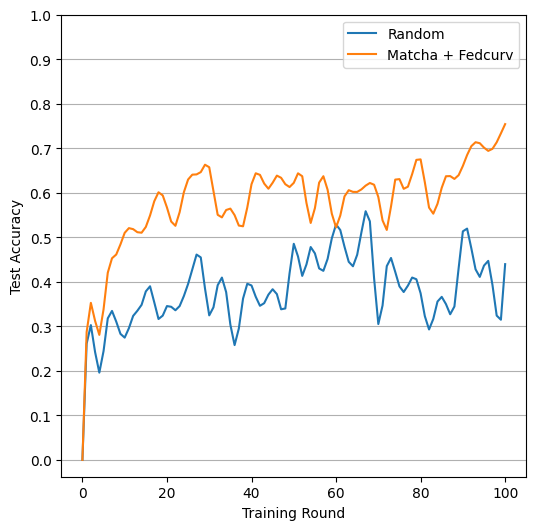

In [48]:
plt.figure(figsize = (6, 6))

plot_results(
    data = data,
    results = results,
    indices = [24, 5],
    legend = ["Random", "Matcha + Fedcurv"],
    smoothen = 100,
    axes = ["Training Round", "Test Accuracy"]
)